In [38]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import copy
import torch
from abc_env_stoch import ABCflow
from naive_agents import DoNothing, FixedPhi
from scipy.optimize import curve_fit
#from dynamic_phi_agent import DynamicPhiAgent
#from dynamic_phi_agent_mean_only import DynamicPhiAgentMeanOnly
#from dynamic_phi_agent_mean_plus_var import DynamicPhiAgent

In [34]:
class Physics_baseline:
    def __init__(self, prescribed_phi,lyapunov_mu, lyapunov_sigma, sample_time, r_d,cost_coef=1, nu = .025):
        self.lyapunov = lyapunov_mu
        self.prescribed_phi = prescribed_phi
        self.cramer_d2 = 1/(lyapunov_sigma**2 * sample_time)
        self.beta = cost_coef
        self.r_d = r_d
        self.nu = nu # ??? this doesn't seem right
        self.a = self.lyapunov + 1/self.cramer_d2
        #self.b =  self.lyapunov + 3/(2*self.cramer_d2)
        print(self.a)
    
    def evaluate(self, seperation,steps_remaining):
        a = self.a
        #b = self.b
        first_term = (seperation**2/self.lyapunov)*np.log(seperation/self.r_d)
        second_term = (self.r_d**2*(self.prescribed_phi-self.lyapunov))/(self.nu*(self.prescribed_phi-a)) #* steps_remaining/4
        #print(seperation)
        #print(f"first:{first_term}")
        #print(f"second:{second_term}")
        #if first_term<0:
        #    print(f"zeroing out{first_term}")
        #    first_term=0
        return (self.prescribed_phi**2 + self.beta) * (first_term + second_term)
        # TODO resovle new baseline

In [59]:
def compare_return_to_baseline(phi_val, baseline, sep_size=0.2*np.pi,num_eps=10,time_horizon=50.):
    labels=["real return", "-b(r)"]
    
    phi_agent = FixedPhi(phi_val)
    
    env = ABCflow(sep_size,a=1.,b=0.7,c=0.43)
    env.deltaT = 0.05
    env.limit = time_horizon
    env.kappa = (0.02*np.pi)**2 * baseline.lyapunov
    step_rewards = np.zeros(int(env.limit/env.deltaT)+1)
    baseline_pred = np.zeros(int(env.limit/env.deltaT)+1)
    sum_distances = np.zeros(int(env.limit/env.deltaT)+1)
    for i in range(0,num_eps):
        time_step=0
        #episode_rew=0
        while not env.isOver():
            action=phi_agent.sample_action(env.getState())
            reward = env.step(action)
            steps_left = env.limit/env.deltaT - time_step
            step_rewards[time_step] += reward
            #baseline_pred[time_step] += -hand_fit(env.dist(),1.1609802 , 0.04960699)
            baseline_pred[time_step] += -baseline.evaluate(env.dist(),steps_left)
            sum_distances[time_step] += env.dist()
            time_step += 1
        env.reset()
        
    returns = np.zeros(int(env.limit/env.deltaT)+1)
    g_return = 0.
    for i in range(len(returns)-1,-1,-1):
        g_return = step_rewards[i] + 0.99*g_return
        returns[i] = g_return
    
    plt.plot(np.arange(len(step_rewards))/(1/env.deltaT),returns/num_eps)
    plt.plot(np.arange(len(step_rewards))/(1/env.deltaT),baseline_pred/num_eps)
    plt.legend(labels)
    plt.title(f"Baseline vs Actual Strategy {phi_val}")
    plt.xlabel("time")
    plt.ylabel("reward")
    plt.savefig(f'baseline_comparison')
    return returns/num_eps, sum_distances/num_eps

0.48222323
zeroing out-0.002771164015859485
zeroing out-0.001703319124257085
zeroing out-0.0022747561510152547
zeroing out-0.002456593814427636
zeroing out-0.0023473571917637464
zeroing out-0.0028520073433171136
zeroing out-0.002737786376969524
zeroing out-0.0021027137776268665
zeroing out-0.0024410451727149046
zeroing out-0.0025722819040261895
zeroing out-0.0021183680476946237
zeroing out-0.002794611054988686
zeroing out-0.001273898309115346
zeroing out-0.0015359029307289965
zeroing out-0.0014632656568251427
zeroing out-0.0015707139023866507
zeroing out-0.000912451431656002
zeroing out-0.0024895901526325493
zeroing out-0.002013792040645971
zeroing out-0.0028585327405626325
zeroing out-0.0019578865854934253
zeroing out-0.002770899970849353
zeroing out-0.002833718847849262
zeroing out-0.0027507427139752327
zeroing out-0.002882266630422273
zeroing out-0.0028819216846004947
zeroing out-0.0028809938215804787
zeroing out-0.0026116943421511715
zeroing out-0.0019312514292139985
zeroing out-0.

zeroing out-0.002481985721432817
zeroing out-0.0017917569101782362
zeroing out-0.0010080607048490843
zeroing out-0.00244553059278915
zeroing out-0.0013431461830980917
zeroing out-0.002378951434385034
zeroing out-0.002872138336399165
zeroing out-0.0025347567640317203
zeroing out-0.002878265338561673
zeroing out-0.0017707030348344606
zeroing out-0.0021713177978883746
zeroing out-0.0013392474368538075
zeroing out-0.001050887016576507
zeroing out-3.1336577603701745e-05
zeroing out-0.002525727704403507
zeroing out-0.002076583632019266
zeroing out-0.0002141649336240195
zeroing out-0.0019719958216941036
zeroing out-0.0023484290161964673
zeroing out-0.002883077998269776
zeroing out-0.002463165546091992
zeroing out-0.0028328394771877327
zeroing out-0.002645504309769492
zeroing out-0.0025799675250448187
zeroing out-0.0027439332478332856
zeroing out-0.00282584632995822
zeroing out-0.0022241602557773917
zeroing out-0.002579810983709082
zeroing out-0.0028419721144667307
zeroing out-0.00273992908028

zeroing out-0.0021213689047454814
zeroing out-0.002669772106983565
zeroing out-0.0027859904442098394
zeroing out-0.0027909930060857524
zeroing out-0.00269250303430161
zeroing out-0.0003361581204961559
zeroing out-0.0019729206329145306
zeroing out-0.0016249026388008784
zeroing out-0.0009967994118356117
zeroing out-0.0003789983815295686
zeroing out-0.002724676407811605
zeroing out-0.002486879099656248
zeroing out-0.0022620040316053253
zeroing out-0.002054966225178691
zeroing out-0.002370523406460579
zeroing out-0.0025601447668631054
zeroing out-0.002817892888106164
zeroing out-0.002840922196896496
zeroing out-0.002697386097235071
zeroing out-0.0010158462318218871
zeroing out-0.0019151186546158077
zeroing out-0.002547830304090196
zeroing out-0.002175009643425158
zeroing out-0.002146255896426129
zeroing out-0.0013965564302863027
zeroing out-0.0013009302018211386
zeroing out-0.002839489608538769
zeroing out-0.0027897103148201616
zeroing out-0.001729122760739604
zeroing out-0.001402350662791

zeroing out-0.0024499123921110327
zeroing out-0.002813967571126691
zeroing out-0.00286968419969859
zeroing out-0.002782669786546887
zeroing out-0.002868470460983689
zeroing out-0.002868843895709746
zeroing out-0.002782388667156347
zeroing out-0.0025802837429912974
zeroing out-0.001911648587434466
zeroing out-0.0028081044066732017
zeroing out-0.0015844124525027446
zeroing out-0.0021043115281928542
zeroing out-0.0005018180659882677
zeroing out-0.0013385718370200624
zeroing out-0.002774453143976462
zeroing out-0.0018782219728880128
zeroing out-0.0028665526796115143
zeroing out-0.002828934129223028
zeroing out-0.0028753791135992966
zeroing out-0.002852770143078002
zeroing out-0.002881534861310888
zeroing out-0.0016244214858829344
zeroing out-0.0014172912785649255
zeroing out-0.0021027312273121487
zeroing out-0.0028193770809282585
zeroing out-0.0026451129934615975
zeroing out-0.002834150917255889
zeroing out-0.002295310572166355
zeroing out-0.0007971019976462059
zeroing out-0.00282341568388

zeroing out-0.002226742340284787
zeroing out-0.0022052600154686924
zeroing out-0.002334124484606492
zeroing out-0.0026034182727736137
zeroing out-0.0026088901014076236
zeroing out-0.0026962947331373405
zeroing out-0.002794999471407648
zeroing out-0.0008339994006748628
zeroing out-0.002561401923710682
zeroing out-0.0025660793704141223
zeroing out-0.002653227793150623
zeroing out-0.0022444678914453203
zeroing out-0.002405673315283545
zeroing out-0.0022208468595835574
zeroing out-0.0004609818555674866
zeroing out-0.0024975635148037274
zeroing out-0.0014793054978786985
zeroing out-0.001013169236984182
zeroing out-0.0005327020549713793
zeroing out-0.0019210437783779002
zeroing out-0.001257450993223543
zeroing out-0.0002473609240351788
zeroing out-0.0020572995436389514
zeroing out-0.001687415716142671
zeroing out-0.0021189557943043606
zeroing out-0.002425150131246456
zeroing out-0.002881683026802698
zeroing out-0.0027618975324063275
zeroing out-0.0025528746656357333
zeroing out-0.00273470160

zeroing out-0.0009868384309395272
zeroing out-0.00226104173678222
zeroing out-0.0025304477770877725
zeroing out-0.0008931656400743851
zeroing out-0.002841231676825034
zeroing out-0.0022703657040822676
zeroing out-0.0028636055394957063
zeroing out-0.002504674699892079
zeroing out-0.0009591364381597596
zeroing out-0.001884724760551311
zeroing out-0.0024736818677859097
zeroing out-0.002880037709111431
zeroing out-0.002696907213349933
zeroing out-0.00287454394477094
zeroing out-0.0026897357216458125
zeroing out-0.0026369793090298657
zeroing out-0.0025792792607555975
zeroing out-0.0028303857596763578
zeroing out-0.002871905129157092
zeroing out-0.002340043482220203
zeroing out-0.0028551920289240093
zeroing out-0.002808432431911536
zeroing out-0.0028325493674985856
zeroing out-0.0025005239180034364
zeroing out-0.002531176160230169
zeroing out-0.002844051391149655
zeroing out-0.00285685497600456
zeroing out-0.0028408279970463367
zeroing out-0.0021461911139560846
zeroing out-0.0026108791748668

zeroing out-0.0015337229351228554
zeroing out-0.002588324379634874
zeroing out-0.0016457943376162523
zeroing out-0.0013106286379627123
zeroing out-0.0008190268961380725
zeroing out-0.0020881498265357132
zeroing out-0.002771137729322566
zeroing out-0.0025798994863359312
zeroing out-0.0028700929755122923
zeroing out-0.0027670946181307158
zeroing out-0.00122669417730164
zeroing out-0.0024054521081082556
zeroing out-0.0026239272368414873
zeroing out-0.0025780569356982806
zeroing out-0.000531842236542417
zeroing out-0.0007062551577333029
zeroing out-0.0005217637313146109
zeroing out-0.0016978951159410695
zeroing out-0.0027546716339760333
zeroing out-0.0028236928949866933
zeroing out-0.002750087068251785
zeroing out-0.002744509943234169
zeroing out-0.0028540412445813767
zeroing out-0.00234931415914103
zeroing out-0.001699941798922366
zeroing out-0.0013427864824486692
zeroing out-0.000648990748303052
zeroing out-0.0020670859581589495
zeroing out-0.0028249870856369625
zeroing out-0.00248028110

zeroing out-0.002098283551378355
zeroing out-0.002856137651289331
zeroing out-0.0022168353999567516
zeroing out-0.0024392465894544912
zeroing out-0.0019564765067776086
zeroing out-0.002541829121128149
zeroing out-0.002882882703152584
zeroing out-0.0021495850222848028
zeroing out-0.002393810617130154
zeroing out-0.002597015916717891
zeroing out-0.0027315790181001716
zeroing out-0.002673582101256903
zeroing out-0.002174508383063202
zeroing out-0.000411530344302718
zeroing out-0.0024987151278954476
zeroing out-2.0595561765329484e-05
zeroing out-0.00033792339056626977
zeroing out-0.0023809243405662293
zeroing out-0.002222857697736945
zeroing out-0.0009609116904424457
zeroing out-2.6555816287408912e-05
zeroing out-0.002337745362595767
zeroing out-0.0011808634688266707
zeroing out-0.0015210163393350414
zeroing out-0.002626869189096196
zeroing out-0.002709819989672424
zeroing out-0.002161979131829674
zeroing out-0.0008383075460028758
zeroing out-0.0014347354353214687
zeroing out-0.00024589734

zeroing out-0.0007428760087883457
zeroing out-0.0006754365279258646
zeroing out-0.0015056350084463913
zeroing out-0.0024219514568504727
zeroing out-0.0014306789981247574
zeroing out-0.0025335026011562125
zeroing out-0.002136911602471432
zeroing out-0.002165555409665889
zeroing out-0.0028545718000975687
zeroing out-0.002383018217292137
zeroing out-0.0023958963759465072
zeroing out-0.002202244428002993
zeroing out-0.0007006242388316477
zeroing out-0.0013073804803116272
zeroing out-0.002849512979696763
zeroing out-0.0026232444396731406
zeroing out-0.0013939202347120188
zeroing out-0.002180510306538616
zeroing out-0.0008211086649891144
zeroing out-0.0010689655828002242
zeroing out-0.0012879913157951353
zeroing out-0.0027940948088617506
zeroing out-0.0024464498624973035
zeroing out-0.0028818902882058314
zeroing out-0.0028486401616558904
zeroing out-0.0023368165556435267
zeroing out-0.0019229013390144511
zeroing out-0.0028737759550481836
zeroing out-0.0024095417006709057
zeroing out-0.000848

zeroing out-0.0019009958675475051
zeroing out-0.0007795694444938917
zeroing out-0.002819437357805403
zeroing out-0.0028310769538018566
zeroing out-0.0023395668875245243
zeroing out-0.0020298850688782104
zeroing out-0.0015027491325829917
zeroing out-0.0024572032602535945
zeroing out-0.0026411373883744164
zeroing out-0.002785938789629004
zeroing out-0.0023580245723602987
zeroing out-0.0028328182987711354
zeroing out-0.0026345952093804153
zeroing out-0.0027021518180338107
zeroing out-0.0028760744165000837
zeroing out-0.0028259558564991336
zeroing out-0.0028705999755239122
zeroing out-0.002720547870762839
zeroing out-0.0021240182569052368
zeroing out-0.00040277890751967563
zeroing out-0.00036179956571158825
zeroing out-0.0001782812004926654
zeroing out-0.0027423439943945315
zeroing out-0.0026633891198138537
zeroing out-0.0010196963216748825
zeroing out-0.0016519366622659815
zeroing out-0.00011296547913002698
zeroing out-0.0016476697918069202
zeroing out-0.001052286358158197
zeroing out-0.0

zeroing out-0.0025967713029309094
zeroing out-0.002310515134459031
zeroing out-0.0025619445012913097
zeroing out-0.0028820849400543296
zeroing out-0.002882755441544743
zeroing out-0.00179283073171218
zeroing out-0.0014843678331927976
zeroing out-0.0014423959686933477
zeroing out-0.0013922362613570645
zeroing out-0.0020772568219778204
zeroing out-0.002004249424200226
zeroing out-0.0005172718933392535
zeroing out-0.0015000715140754005
zeroing out-0.002005612886442955
zeroing out-0.002696187580961891
zeroing out-0.002351558662834403
zeroing out-0.002675884145391539
zeroing out-0.0028079059468957197
zeroing out-0.0026500226386965
zeroing out-0.0022335618204063525
zeroing out-0.0017668805766057726
zeroing out-0.002423008335631729
zeroing out-0.0015171151218525316
zeroing out-0.002315686597710428
zeroing out-0.0017213365657813944
zeroing out-0.002581020906669074
zeroing out-0.0028441785973977417
zeroing out-0.002646689779085457
zeroing out-0.002174997593386155
zeroing out-0.00031849159420492

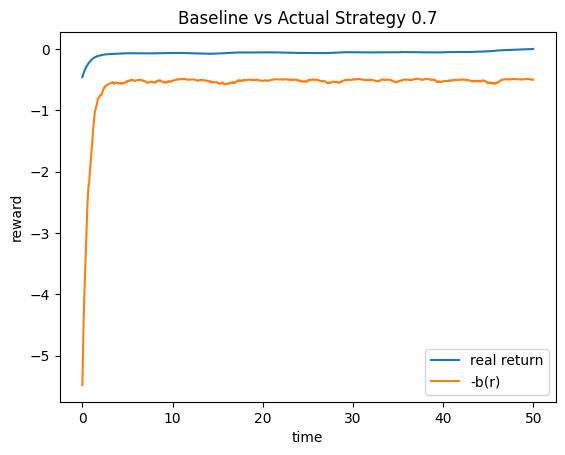

In [60]:
phi_val = 0.7
phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,3.,0.02*np.pi) 
avg_returns,seperation = compare_return_to_baseline(phi_val,phi_aproximator)

In [51]:
avg_returns.shape

(1001,)

In [52]:
def hand_fit(x,a,b):
    #phi = 0.75
    #beta = 1
    return a*x**2+b#(phi**2+beta)*(a*x**2+b)

In [57]:
curve_fit(hand_fit,seperation,-avg_returns)

(array([1.25924921, 0.03251795]),
 array([[ 1.79675002e-04, -8.05252964e-07],
        [-8.05252964e-07,  8.20536806e-08]]))

0.48222323


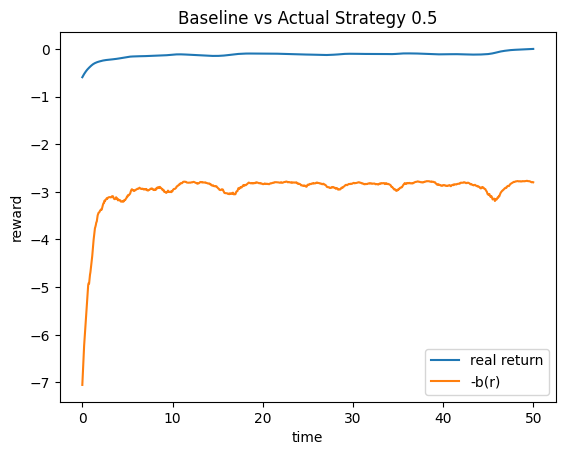

In [18]:
phi_val = 0.5
phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,3.,0.02*np.pi) 
compare_return_to_baseline(phi_val,phi_aproximator)

0.48222323


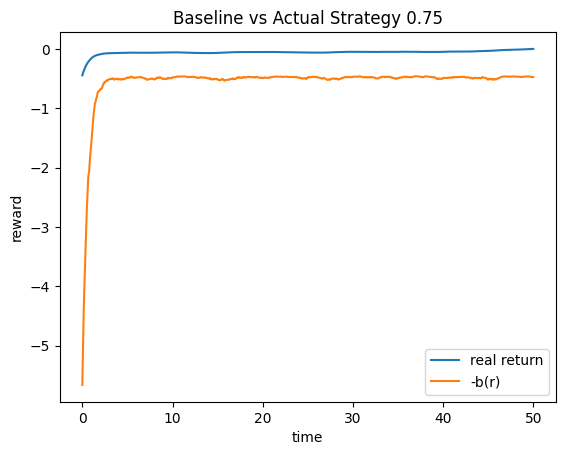

In [5]:
phi_val = 0.75
phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,3.,0.02*np.pi) 
compare_return_to_baseline(phi_val,phi_aproximator)

0.48222323
zeroing out-0.00017102520063162383
zeroing out-0.002493930325572157
zeroing out-0.0026633336737353344
zeroing out-0.002546343315094658
zeroing out-0.00269072903663094
zeroing out-0.0027860417511911826
zeroing out-0.0027149743192478753
zeroing out-0.0028121572637384708
zeroing out-0.0006106928350820232
zeroing out-0.0022158620374885685
zeroing out-0.001175136532350481
zeroing out-0.0020148929357502172
zeroing out-0.0028730849165065123
zeroing out-0.0026565182307586232
zeroing out-0.0025055464529176287
zeroing out-0.0014241964232240313
zeroing out-0.00039749959725990765
zeroing out-6.164653084873831e-05
zeroing out-0.001668041261647159
zeroing out-0.002220153433759619
zeroing out-0.0014444307981892716
zeroing out-0.0005878064624799562
zeroing out-0.002224795270891687
zeroing out-0.0014610952404633501
zeroing out-0.0015084974613585268
zeroing out-0.0028598315224682984
zeroing out-0.0028427157283021473
zeroing out-0.002852250810972353
zeroing out-0.0016993621593330748
zeroing ou

zeroing out-0.002032752770898679
zeroing out-0.0012760808293036945
zeroing out-0.0028658303733171274
zeroing out-0.002848010060073113
zeroing out-0.0028744548450294837
zeroing out-0.0017619023310037523
zeroing out-0.001866336769196441
zeroing out-0.0007661816813260549
zeroing out-0.002513046652117312
zeroing out-0.002220526315513142
zeroing out-0.0013691720397524824
zeroing out-0.0018223400430131653
zeroing out-0.0002274323565585927
zeroing out-0.0011552885933486373
zeroing out-0.0022757578205896576
zeroing out-0.0018241405389203367
zeroing out-0.00288303780582195
zeroing out-0.0028814051633585277
zeroing out-0.002878014489362563
zeroing out-0.0025358259664686844
zeroing out-0.0005085066249500906
zeroing out-0.0018437317608089587
zeroing out-0.0027930262322250748
zeroing out-0.0025959168498680906
zeroing out-0.0025600055354764602
zeroing out-0.002367070483245833
zeroing out-0.0027162718561027054
zeroing out-0.0019822032081458028
zeroing out-0.0009989474046716016
zeroing out-0.000418125

zeroing out-0.001655340170176491
zeroing out-0.00014056711030074206
zeroing out-0.002042454579530393
zeroing out-0.002711450404518684
zeroing out-0.0019186682889665752
zeroing out-0.0017360413147278458
zeroing out-0.0009817463392533504
zeroing out-0.001272317441572797
zeroing out-0.00016850210456882287
zeroing out-0.002490734147231266
zeroing out-0.002651032109283702
zeroing out-0.002831736067876983
zeroing out-0.0025679819473471573
zeroing out-0.002851579516194559
zeroing out-0.002726708793446249
zeroing out-0.0027293604052489487
zeroing out-0.002449257968219358
zeroing out-0.0013281863979288763
zeroing out-0.0017610815906285177
zeroing out-0.002363795809903523
zeroing out-0.002201545843322485
zeroing out-0.0012870321551978077
zeroing out-0.0023576563114597725
zeroing out-0.0026870197126463644
zeroing out-0.0028823718260495438
zeroing out-0.0027861458975081076
zeroing out-0.0028673150273845526
zeroing out-0.0028758326745129325
zeroing out-0.0028724569010221013
zeroing out-0.0028285892

zeroing out-0.0007688362856459872
zeroing out-0.0007261778867761489
zeroing out-0.0021969007585368335
zeroing out-0.00011413787513438363
zeroing out-0.001680525514117113
zeroing out-0.0022474863368121475
zeroing out-0.0019234139662087453
zeroing out-0.0019870391950754596
zeroing out-0.0028118533654774244
zeroing out-0.0026246356768692713
zeroing out-0.00269639949534566
zeroing out-0.0028826129316886794
zeroing out-0.0005847561923511537
zeroing out-0.0006082459169437738
zeroing out-0.0028081627842882328
zeroing out-0.0026558597837186455
zeroing out-0.0027822900792162817
zeroing out-0.002783569342919878
zeroing out-0.002815621729533197
zeroing out-0.0028741889832601944
zeroing out-0.002393809476315535
zeroing out-0.002344188866346263
zeroing out-0.0016375956145068939
zeroing out-0.0025702868976357827
zeroing out-0.0017969912850277366
zeroing out-0.0003943318550315242
zeroing out-0.0011208553510045846
zeroing out-0.0018051597834855802
zeroing out-0.002850602977535355
zeroing out-0.0028812

zeroing out-0.0014943280353118444
zeroing out-0.0028642864622099823
zeroing out-0.0026076497024737377
zeroing out-0.002576750190397463
zeroing out-0.0008282723696727331
zeroing out-0.002028209598081959
zeroing out-0.002564474687276248
zeroing out-0.0028750628368408855
zeroing out-0.002779009832596441
zeroing out-0.001591905459430733
zeroing out-0.002779465765804545
zeroing out-0.0028619477075915154
zeroing out-0.0026497691737065177
zeroing out-0.002644813261676881
zeroing out-0.002660906005118918
zeroing out-0.0028526365809526913
zeroing out-0.002866285931444679
zeroing out-0.0018393768253651896
zeroing out-0.0024238482583666576
zeroing out-0.0007802455310855851
zeroing out-0.0004458287616594095
zeroing out-0.001366523390370692
zeroing out-0.0019283649972534347
zeroing out-0.002239622624441957
zeroing out-0.0011531290249750979
zeroing out-0.002443682517250557
zeroing out-0.002208507445135267
zeroing out-0.001391293240199044
zeroing out-0.0021143553074943065
zeroing out-0.00055873186403

zeroing out-0.0024158234362581348
zeroing out-0.002083941621680734
zeroing out-0.002239084884262505
zeroing out-0.0027921437668826776
zeroing out-0.002508537708639489
zeroing out-0.0015784756385953064
zeroing out-0.002853633222957606
zeroing out-0.002521863358080165
zeroing out-0.001974014083833706
zeroing out-0.0027370228843308446
zeroing out-0.0027680375681263187
zeroing out-0.002798101324224775
zeroing out-0.002870930045496191
zeroing out-0.002321233117028157
zeroing out-0.00286023710566111
zeroing out-0.0028225197530319674
zeroing out-0.0028389957006521582
zeroing out-0.0028260681224267286
zeroing out-0.0024556401017001624
zeroing out-0.0027782867975520826
zeroing out-0.002796920348923912
zeroing out-0.0028829348904434587
zeroing out-0.0019985776698414224
zeroing out-0.0027665235219296556
zeroing out-0.0028739961695822365
zeroing out-0.0028229650267015977
zeroing out-0.0028747901615357027
zeroing out-0.0018826555927525667
zeroing out-0.0016503849059424074
zeroing out-0.001877392823

zeroing out-0.00263030097596479
zeroing out-0.002843491520916568
zeroing out-0.0021864737575572513
zeroing out-0.0012732270000957203
zeroing out-0.0014705802659573989
zeroing out-0.0020179882993287277
zeroing out-0.002872220884656793
zeroing out-0.002480713872921407
zeroing out-0.0028775326279551834
zeroing out-0.0027620775820513467
zeroing out-0.002750893369019922
zeroing out-0.002106852333713442
zeroing out-0.000989879553591455
zeroing out-0.0008589753611031433
zeroing out-0.001129148715694366
zeroing out-0.0014946026795982237
zeroing out-0.0024481670356906447
zeroing out-0.002603136366771363
zeroing out-0.00275602822155844
zeroing out-0.0026296260604842104
zeroing out-0.002139825751664664
zeroing out-0.002823933256030769
zeroing out-0.0028212151952972625
zeroing out-0.002165941043521576
zeroing out-0.002425969322621027
zeroing out-0.0028796879392257823
zeroing out-0.002878820797542067
zeroing out-0.002466898621030114
zeroing out-0.0027425995701177526
zeroing out-0.002738937913832929

zeroing out-0.002199474549945834
zeroing out-0.0014409134766326934
zeroing out-0.002433784203124872
zeroing out-0.0022746216219681993
zeroing out-0.002869782211159662
zeroing out-0.0025156073727999645
zeroing out-0.002545286168206227
zeroing out-0.0028461528005096362
zeroing out-0.002881601418852455
zeroing out-0.0021743853498148876
zeroing out-0.002344426965985379
zeroing out-0.0022111884154396287
zeroing out-0.0014987818706004956
zeroing out-0.0004400386416037428
zeroing out-0.0016613772537262528
zeroing out-0.0019540750175356804
zeroing out-0.00010606479030447908
zeroing out-0.0025759892818168206
zeroing out-0.002811175029865769
zeroing out-0.0028830918093908087
zeroing out-0.0026317852188231733
zeroing out-0.0028709774756236575
zeroing out-0.0023600988348121948
zeroing out-0.0025179894915058425
zeroing out-0.0005418276689225154
zeroing out-0.0020007784802182644
zeroing out-0.0016702981641017872
zeroing out-0.0028226541501295507
zeroing out-0.0005725931685965955
zeroing out-0.002810

zeroing out-0.0027816342539997065
zeroing out-0.0028044549933040224
zeroing out-0.0027908222637758415
zeroing out-0.002878758695468546
zeroing out-0.0028801867091752887
zeroing out-0.00040773682290456113
zeroing out-0.00025040020667062204
zeroing out-0.002816471992850859
zeroing out-0.002729085792271134
zeroing out-0.0008273203547576658
zeroing out-0.0007191170759681848
zeroing out-0.0019045945346731145
zeroing out-0.0010772386508253174
zeroing out-0.0007475587051554061
zeroing out-0.0026696808332660697
zeroing out-0.0024528007713750894
zeroing out-0.0027319859219706254
zeroing out-0.0027083688633141373
zeroing out-0.0025442422140470903
zeroing out-0.0018274445223999158
zeroing out-0.0028001306741931003
zeroing out-0.0025767430129781297
zeroing out-0.0024916467669384573
zeroing out-0.0028308200349294035
zeroing out-0.00251901316158048
zeroing out-0.002390700414096322
zeroing out-0.0027765430640172934
zeroing out-0.002829948328590135
zeroing out-0.0028732455412028273
zeroing out-0.00282

zeroing out-0.00014401917684432654
zeroing out-0.0014286871891445241
zeroing out-0.0010828082209481866
zeroing out-0.0011915643681370254
zeroing out-0.001806109022969996
zeroing out-0.001357941966061462
zeroing out-0.0018363941292471096
zeroing out-0.0018412020654976935
zeroing out-0.0028344192633227277
zeroing out-0.002585628987372518
zeroing out-0.0024138224824942593
zeroing out-0.002866468136562061
zeroing out-0.002832374434045313
zeroing out-0.0027768497560417475
zeroing out-0.002857780408885794
zeroing out-0.002687140799999155
zeroing out-0.0028752048698527607
zeroing out-0.002591051407815602
zeroing out-0.0028634959096797835
zeroing out-0.0022177712304636684
zeroing out-0.00263099284808728
zeroing out-0.0023056882512921756
zeroing out-0.0027120327832315964
zeroing out-0.002679573009491137
zeroing out-0.002360309445704517
zeroing out-0.002750445250477989
zeroing out-0.002378565654709959
zeroing out-0.002718719918910125
zeroing out-0.001944134448439976
zeroing out-0.002881450535882

zeroing out-0.0022585715678540186
zeroing out-0.0023786925503151025
zeroing out-0.002867133260785793
zeroing out-0.0028822583934647256
zeroing out-0.0020586093034821325
zeroing out-0.001820113508427161
zeroing out-0.0025347547704602153
zeroing out-0.0028681421910064105
zeroing out-0.0027467766816608673
zeroing out-0.0009333729938569601
zeroing out-0.0025304619425771083
zeroing out-0.0028830772939891242
zeroing out-0.002807112139001722
zeroing out-0.0019783290689132033
zeroing out-0.0001161165591031626
zeroing out-0.0016070299019563911
zeroing out-0.001016782972961195
zeroing out-0.002846555603018961
zeroing out-0.0024874677642673163
zeroing out-0.002286446765025325
zeroing out-0.0028781824533453846
zeroing out-0.002877282297017025
zeroing out-0.0015775844677265159
zeroing out-0.0009389464772017712
zeroing out-0.0016541411293107757
zeroing out-0.00013260823819187694
zeroing out-0.002411679089818561
zeroing out-0.0027578092913049775
zeroing out-0.0028323786172808926
zeroing out-0.0018301

zeroing out-0.0028632620315860603
zeroing out-0.002793341569030551
zeroing out-0.0025484024458500053
zeroing out-0.0009870211947925966
zeroing out-0.0013225129009194266
zeroing out-0.001926188557781406
zeroing out-0.0027944282411809613
zeroing out-0.0020403514741518503
zeroing out-0.0023306459524533407
zeroing out-0.001650007285038011
zeroing out-0.0025649001207888327
zeroing out-0.0009444836744237415
zeroing out-0.0021265056701907765
zeroing out-0.0019581350083812464
zeroing out-0.0018198072042439211
zeroing out-0.002202415394118639
zeroing out-0.0025271603877344757
zeroing out-0.002084915592356625
zeroing out-0.0028034057308741383
zeroing out-0.002874296283659237
zeroing out-0.002070464034120856
zeroing out-0.000718345505605542
zeroing out-0.0005721377080217395
zeroing out-0.00157020300160739
zeroing out-0.0012806505577348842
zeroing out-0.0022840336338913474
zeroing out-0.002322847367663603
zeroing out-0.002522423403926293
zeroing out-0.0028506666521995044
zeroing out-0.002810425426

zeroing out-0.0004198744942432471
zeroing out-0.002388321378348404
zeroing out-0.002882061627826081
zeroing out-0.0015545661897839822
zeroing out-0.001825984053806085
zeroing out-0.0026393842605764322
zeroing out-0.0020366898592082475
zeroing out-0.0026143918163465305
zeroing out-0.0023879739275455038
zeroing out-0.0013877839597694172
zeroing out-0.00113481105180446
zeroing out-0.002290940103234176
zeroing out-0.002743538140141606
zeroing out-0.0028140323344690243
zeroing out-0.0028579390108486695
zeroing out-0.0028830614602440925
zeroing out-0.0012878339091817387
zeroing out-0.0017379513780645622
zeroing out-0.0028562436866750554
zeroing out-0.0028255137452709157
zeroing out-0.002566775864613312
zeroing out-0.0028817744384634068
zeroing out-0.002499415262026821
zeroing out-0.002150253155652577
zeroing out-0.0022180363134390716
zeroing out-0.0009159903255004819
zeroing out-0.0004962660692348394
zeroing out-0.0015008956053547665
zeroing out-0.0003865588039436291
zeroing out-0.0005760577

zeroing out-0.0013338750949518068
zeroing out-0.0028587679998904815
zeroing out-0.002638942837886558
zeroing out-0.0028792173038594457
zeroing out-0.0027420333577213027
zeroing out-0.002879315000649907
zeroing out-0.0016781977896014543
zeroing out-0.0019672459281344693
zeroing out-0.0025008884845716334
zeroing out-0.0017215190035903343
zeroing out-0.0019896894049831293
zeroing out-0.00202402795446193
zeroing out-0.0026330391588964275
zeroing out-0.0024712769472712425
zeroing out-0.002191383085584953
zeroing out-0.0028783563445873876
zeroing out-0.00254568424696754
zeroing out-0.002543222582623956
zeroing out-0.0005222153872966297
zeroing out-0.0009895306575336492
zeroing out-0.0028794880718060615
zeroing out-0.002650393980095424
zeroing out-0.0015567878509793358
zeroing out-0.0006265865275654537
zeroing out-0.0015622353331552843
zeroing out-0.002882864302921054
zeroing out-0.0028371743093888614
zeroing out-0.002226835498777637
zeroing out-0.002693493627041116
zeroing out-0.002588334202

zeroing out-0.0016705079533018926
zeroing out-0.0025218497558623792
zeroing out-0.0028777416962038295
zeroing out-0.002883028699551026
zeroing out-0.002533956129943295
zeroing out-0.002791572955245801
zeroing out-0.0018996027150051072
zeroing out-0.0016754401950695305
zeroing out-0.002649918491613739
zeroing out-0.002810000555146301
zeroing out-0.0024657196341863136
zeroing out-0.0028819811327276622
zeroing out-0.002871421709934076
zeroing out-0.0011863278142943362
zeroing out-0.0007454883497912597
zeroing out-0.001566538761152347
zeroing out-0.0026109396191714945
zeroing out-0.0023637106623390423
zeroing out-0.0028825179114173325
zeroing out-0.002174298814496886
zeroing out-0.0008358987253095726
zeroing out-0.002838933216715866
zeroing out-0.0028829784444172283
zeroing out-0.0028828272212046515
zeroing out-0.0028258918636723403
zeroing out-0.0028802391058339884
zeroing out-0.0027133527613625755
zeroing out-0.0017975790836641113
zeroing out-0.000795296697428961
zeroing out-0.0021953737

zeroing out-0.0008010564927401347
zeroing out-0.00287363935290324
zeroing out-0.0024870336043114356
zeroing out-0.0028429823882476658
zeroing out-0.002759497672057432
zeroing out-0.002209032868141145
zeroing out-0.0028059030480259016
zeroing out-0.002005769393179029
zeroing out-0.0014644757364849327
zeroing out-0.0025579931505068155
zeroing out-0.0020671519860490165
zeroing out-9.233880768357648e-05
zeroing out-0.002399138509886671
zeroing out-0.001520042565152226
zeroing out-0.002604375960783923
zeroing out-0.002792651718794169
zeroing out-0.0028765448046999113
zeroing out-0.002561321672780265
zeroing out-0.0024145501207213315
zeroing out-0.0028818520957393317
zeroing out-0.0028667318465626294
zeroing out-0.0027780677858880646
zeroing out-0.002514658769081086
zeroing out-0.0013080306894643217
zeroing out-0.0022164905204152424
zeroing out-0.0023579140086332734
zeroing out-0.0018162586342990205
zeroing out-0.002477242425785853
zeroing out-0.002840358666718284
zeroing out-0.0026048123023

zeroing out-0.0023920429987340226
zeroing out-0.0028491049461694495
zeroing out-0.0028379634627024647
zeroing out-0.0027845310580680003
zeroing out-0.0026980395350523967
zeroing out-0.0028742015418954103
zeroing out-0.0028816453080070903
zeroing out-0.002802813124500065
zeroing out-0.0018655945327928625
zeroing out-0.0015376570842696967
zeroing out-0.002506567175118455
zeroing out-0.002805520895729178
zeroing out-0.0027823437016679057
zeroing out-0.002722240476213915
zeroing out-0.002525980032146882
zeroing out-0.002770034629879885
zeroing out-0.0028690499731684744
zeroing out-0.002601304209112711
zeroing out-0.0028827924824146875
zeroing out-0.0026753178673743026
zeroing out-0.002037580856980412
zeroing out-0.0020046614440942935
zeroing out-0.0028762108783140557
zeroing out-0.0026712133917804475
zeroing out-0.0027564894361480604
zeroing out-0.0018945554455806937
zeroing out-0.0009274149199400947
zeroing out-0.0017979285640002296
zeroing out-0.0009464364896580412
zeroing out-0.00272705

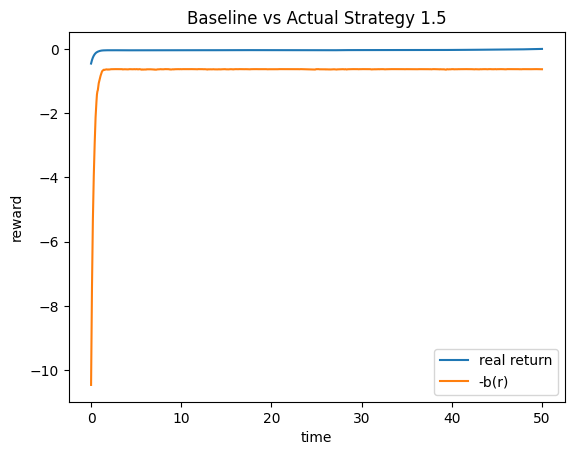

In [37]:
phi_val = 1.5
phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,3.,0.02*np.pi) 
compare_return_to_baseline(phi_val,phi_aproximator)

0.48222323


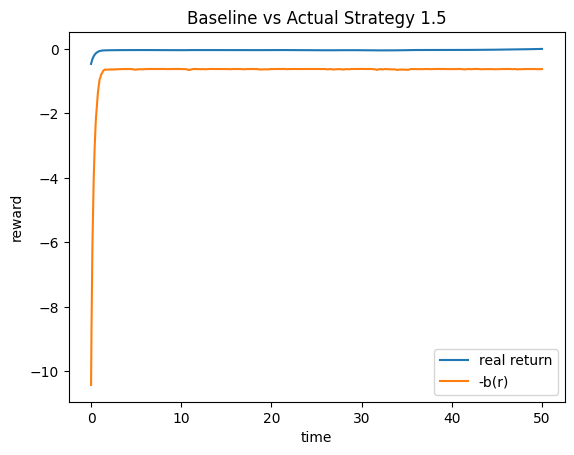

In [12]:
phi_val = 1.5
phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,3.,0.02*np.pi) 
compare_return_to_baseline(phi_val,phi_aproximator)

In [7]:
assert(1==0)

AssertionError: 

In [ ]:
for i in range(5,11):
    phi_val = i/10
    phi_aproximator = Physics_baseline(phi_val,0.25187,0.27710,5.,0.02*np.pi) 
    compare_return_to_baseline(phi_val,phi_aproximator)

In [ ]:
for i in range(5,11):
    phi_val = i/10
    print(phi_val)
    phi_agent = FixedPhi(phi_val)
    compare_return_to_baseline(phi_agent,f"phi={phi_agent.phi}",phi_aproximator)

In [ ]:
phi_val = 0.5
phi_aproximator = Physics_baseline(phi_val,0.18265,0.17904,5.) 
phi_agent = FixedPhi(1.1)
compare_return_to_baseline(phi_agent,f"phi={phi_agent.phi}",phi_aproximator)

In [ ]:
#compare_return_to_baseline(phi_agent,f"phi={phi_agent.phi}",phi_aproximator)
phi_val = 0.8
phi_aproximator = Physics_baseline(phi_val,0.16980,0.12038,10.) 
phi_agent = FixedPhi(1.0)
compare_return_to_baseline(phi_agent,"phi=1.0",phi_aproximator, time_horizon=10.)

In [ ]:
phi_aproximator.evaluate(np.array([0.02,0.018]))

In [ ]:
phi_aproximator.evaluate(0.018)

In [ ]:
x=np.array([[0.02,0.018],
        [1.,1.2]])
torch.linalg.norm(torch.tensor(x), axis=1)

In [ ]:
np.log(2.7)

In [30]:
from itertools import accumulate
x=np.ones((3,3))
np.array(list(accumulate(x, lambda x,y: x*0.01+y)))

array([[1.    , 1.    , 1.    ],
       [1.01  , 1.01  , 1.01  ],
       [1.0101, 1.0101, 1.0101]])

In [21]:
np.hstack((np.zeros(3),np.random.normal(size=3)))

array([ 0.        ,  0.        ,  0.        , -0.86886506, -1.54960072,
        1.10206635])